# Coupling a Landlab groundwater with a Mesa agent-based model

This notebook shows a toy example of how one might couple a simple groundwater model (Landlab's `GroundwaterDupuitPercolator`, by [Litwin et al. (2020)](https://joss.theoj.org/papers/10.21105/joss.01935)) with an agent-based model (ABM) written using the [Mesa](https://mesa.readthedocs.io/en/latest/) Agent-Based Modeling (ABM) package.

The purpose of this tutorial is to demonstrate the technical aspects of creating an integrated Landlab-Mesa model. The example is deliberately very simple in terms of the processes and interactions represented, and not meant to be a realistic portrayal of water-resources decision making. But the example does show how one might build a more sophisticated and interesting model using these basic ingredients.

(Greg Tucker, November 2021; created from earlier notebook example used in May 2020
workshop)

## Running the groundwater model

The following section simply illustrates how to create a groundwater model using the `GroundwaterDupuitPercolator` component.

Imports:

In [1]:
from landlab import RasterModelGrid, imshow_grid
from landlab.components import GroundwaterDupuitPercolator
import matplotlib.pyplot as plt

Set parameters:

In [2]:
base_depth = 22.0  # depth of aquifer base below ground level, m
initial_water_table_depth = 2.0  # starting depth to water table, m
dx = 100.0  # cell width, m
pumping_rate = 0.001  # pumping rate, m3/s
well_locations = [800, 1200]
K = 0.001  # hydraulic conductivity, (m/s)
n = 0.2  # porosity, (-)
dt = 3600.0  # time-step duration, s
background_recharge = 0.1 / (3600 * 24 * 365.25)  # recharge rate from infiltration, m/s

Create a grid and add fields:

In [3]:
# Raster grid with closed boundaries
# boundaries = {'top': 'closed','bottom': 'closed','right':'closed','left':'closed'}
grid = RasterModelGrid((41, 41), xy_spacing=dx)  # , bc=boundaries)

# Topographic elevation field (meters)
elev = grid.add_zeros("topographic__elevation", at="node")

# Field for the elevation of the top of an impermeable geologic unit that forms
# the base of the aquifer (meters)
base = grid.add_zeros("aquifer_base__elevation", at="node")
base[:] = elev - base_depth

# Field for the elevation of the water table (meters)
wt = grid.add_zeros("water_table__elevation", at="node")
wt[:] = elev - initial_water_table_depth

# Field for the groundwater recharge rate (meters per second)
recharge = grid.add_zeros("recharge__rate", at="node")
recharge[:] = background_recharge
recharge[well_locations] -= pumping_rate / (
    dx * dx
)  # pumping rate, in terms of recharge

Instantiate the component (note use of an array/field instead of a scalar constant for `recharge_rate`):

In [4]:
gdp = GroundwaterDupuitPercolator(
    grid,
    hydraulic_conductivity=K,
    porosity=n,
    recharge_rate=recharge,
    regularization_f=0.01,
)

Define a couple of handy functions to run the model for a day or a year:

In [5]:
def run_for_one_day(gdp, dt):
    num_iter = int(3600.0 * 24 / dt)
    for _ in range(num_iter):
        gdp.run_one_step(dt)

In [6]:
def run_for_one_year(gdp, dt):
    num_iter = int(365.25 * 3600.0 * 24 / dt)
    for _ in range(num_iter):
        gdp.run_one_step(dt)

Run for a year and plot the water table:

In [7]:
run_for_one_year(gdp, dt)

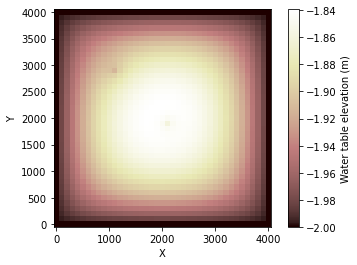

In [8]:
imshow_grid(grid, wt, colorbar_label="Water table elevation (m)")

### Aside: calculating a pumping rate in terms of recharge

The pumping rate at a particular grid cell (in volume per time, representing pumping from a well at that location) needs to be given in terms of a recharge rate (depth of water equivalent per time) in a given grid cell. Suppose for example you're pumping 16 gallons/minute (horrible units of course). That equates to:

16 gal/min x 0.00378541 m3/gal x (1/60) min/sec =

In [ ]:
Qp = 16.0 * 0.00378541 / 60.0
print(Qp)

...equals about 0.001 m$^3$/s. That's $Q_p$. The corresponding negative recharge in a cell of dimensions $\Delta x$ by $\Delta x$ would be

$R_p = Q_p / \Delta x^2$

In [ ]:
Rp = Qp / (dx * dx)
print(Rp)

## A very simple ABM with farmers who drill wells into the aquifer

For the sake of illustration, our ABM will be extremely simple. There are $N$ farmers, at random locations, who each pump at a rate $Q_p$ as long as the water table lies above the depth of their well, $d_w$. Once the water table drops below their well, the well runs dry and they switch from crops to pasture.

### Check that Mesa is installed

For the next step, we must verify that Mesa is available. If it is not, use one of the installation commands below to install, then re-start the kernel (Kernel => Restart) and continue.

In [ ]:
try:
    from mesa import Model
except ModuleNotFoundError:
    print(
        """
Mesa needs to be installed in order to run this notebook.

Normally Mesa should be pre-installed alongside the Landlab notebook collection. 
But it appears that Mesa is not already installed on the system on which you are
running this notebook. You can install Mesa from a command prompt using either:

`conda install -c conda-forge mesa`

or

`pip install mesa`
    """
    )
    raise

### Defining the ABM

In Mesa, an ABM is created using a class for each Agent and a class for the Model. Here's the Agent class (a Farmer). Farmers have a grid location and an attribute: whether they are actively pumping their well or not. They also have a well depth: the depth to the bottom of their well. Their action consists of checking whether their well is wet or dry; if wet, they will pump, and if dry, they will not.

In [ ]:
from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.time import RandomActivation

In [ ]:
class FarmerAgent(Agent):
    """An agent who pumps from a well if it's not dry."""

    def __init__(self, unique_id, model, well_depth=5.0):
        super().__init__(unique_id, model)
        self.pumping = True
        self.well_depth = well_depth

    def step(self):
        x, y = self.pos
        print(f"Farmer {self.unique_id}, ({x}, {y})")
        print(f"    Depth to the water table: {self.model.wt_depth_2d[x,y]}")
        print(f"    Depth to the bottom of the well: {self.well_depth}")
        if self.model.wt_depth_2d[x, y] >= self.well_depth:  # well is dry
            print("    Well is dry.")
            self.pumping = False
        else:
            print("    Well is pumping.")
            self.pumping = True

Next, define the model class. The model will take as a parameter a reference to a 2D array (with the same dimensions as the grid) that contains the depth to water table at each grid location. This allows the Farmer agents to check whether their well has run dry.

In [ ]:
class FarmerModel(Model):
    """A model with several agents on a grid."""

    def __init__(self, N, width, height, well_depth, depth_to_water_table):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.depth_to_water_table = depth_to_water_table
        self.schedule = RandomActivation(self)

        # Create agents
        for i in range(self.num_agents):
            a = FarmerAgent(i, self, well_depth)
            self.schedule.add(a)
            # Add the agent to a random grid cell (excluding the perimeter)
            x = self.random.randrange(self.grid.width - 2) + 1
            y = self.random.randrange(self.grid.width - 2) + 1
            self.grid.place_agent(a, (x, y))

    def step(self):
        self.wt_depth_2d = self.depth_to_water_table.reshape(
            (self.grid.width, self.grid.height)
        )
        self.schedule.step()

### Setting up the Landlab grid, fields, and groundwater simulator

In [ ]:
base_depth = 22.0  # depth of aquifer base below ground level, m
initial_water_table_depth = 2.8  # starting depth to water table, m
dx = 100.0  # cell width, m
pumping_rate = 0.004  # pumping rate, m3/s
well_depth = 3  # well depth, m
background_recharge = 0.002 / (365.25 * 24 * 3600)  # recharge rate, m/s
K = 0.001  # hydraulic conductivity, (m/s)
n = 0.2  # porosity, (-)
dt = 3600.0  # time-step duration, s
num_agents = 12  # number of farmer agents
run_duration_yrs = 15  # run duration in years

In [ ]:
grid = RasterModelGrid((41, 41), xy_spacing=dx)

elev = grid.add_zeros("topographic__elevation", at="node")

base = grid.add_zeros("aquifer_base__elevation", at="node")
base[:] = elev - base_depth

wt = grid.add_zeros("water_table__elevation", at="node")
wt[:] = elev - initial_water_table_depth

depth_to_wt = grid.add_zeros("water_table__depth_below_ground", at="node")
depth_to_wt[:] = elev - wt

recharge = grid.add_zeros("recharge__rate", at="node")
recharge[:] = background_recharge
recharge[well_locations] -= pumping_rate / (
    dx * dx
)  # pumping rate, in terms of recharge

In [ ]:
gdp = GroundwaterDupuitPercolator(
    grid,
    hydraulic_conductivity=K,
    porosity=n,
    recharge_rate=recharge,
    regularization_f=0.01,
)

### Set up the Farmer model

In [ ]:
nc = grid.number_of_node_columns
nr = grid.number_of_node_rows
farmer_model = FarmerModel(
    num_agents, nc, nr, well_depth, depth_to_wt.reshape((nr, nc))
)

Check the spatial distribution of wells:

In [ ]:
import numpy as np


def get_well_count(model):
    well_count = np.zeros((nr, nc), dtype=int)
    pumping_well_count = np.zeros((nr, nc), dtype=int)
    for cell in model.grid.coord_iter():
        cell_content, x, y = cell
        well_count[x][y] = len(cell_content)
        for agent in cell_content:
            if agent.pumping:
                pumping_well_count[x][y] += 1
    return well_count, pumping_well_count


well_count, p_well_count = get_well_count(farmer_model)
imshow_grid(grid, well_count.flatten())

#### Set the initial recharge field

In [ ]:
recharge[:] = -(pumping_rate / (dx * dx)) * p_well_count.flatten()
imshow_grid(grid, -recharge * 3600 * 24, colorbar_label="Pumping rate (m/day)")

### Run the model

In [ ]:
for i in range(run_duration_yrs):
    # Run the groundwater simulator for one year
    run_for_one_year(gdp, dt)

    # Update the depth to water table
    depth_to_wt[:] = elev - wt

    # Run the farmer model
    farmer_model.step()

    # Count the number of pumping wells
    well_count, pumping_well_count = get_well_count(farmer_model)
    total_pumping_wells = np.sum(pumping_well_count)
    print(f"In year {i + 1} there are {total_pumping_wells} pumping wells")
    print(f" and the greatest depth to water table is {np.amax(depth_to_wt)} meters.")

    # Update the recharge field according to current pumping rate
    recharge[:] = (
        background_recharge - (pumping_rate / (dx * dx)) * pumping_well_count.flatten()
    )
    print(f"Total recharge: {np.sum(recharge)}")
    print("")

    plt.figure()
    imshow_grid(grid, wt)

In [ ]:
imshow_grid(grid, wt)

In [ ]:
# Display the area of water table that lies below the well depth
depth_to_wt[:] = elev - wt
too_deep = depth_to_wt > well_depth
imshow_grid(grid, too_deep)

This foregoing example is very simple, and leaves out many aspects of the complex problem of water extraction as a "tragedy of the commons". But it does illustrate how one can build a model that integrates agent-based dynamics with continuum dynamics by combining Landlab grid-based model code with Mesa ABM code.